In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

In [4]:
data_counts = data['Market'].value_counts()
data_counts

Market
China             1003
United States      895
India              713
United Kingdom     648
Japan              503
Canada             419
Australia          396
Hong Kong          376
Malaysia           361
Sweden             322
Germany            293
France             196
Thailand           191
Taiwan             187
Switzerland        178
Korea              175
Brazil             129
Italy              128
Turkey             117
South Africa       114
Mexico              99
Norway              93
Singapore           92
Indonesia           88
Finland             73
Spain               72
Denmark             64
Netherlands         58
New Zealand         58
Argentina           56
Morocco             50
Belgium             49
Chile               46
Poland              42
Egypt               35
Peru                34
Austria             32
Vitnam              26
Greece              25
Colombia            21
Portugal            16
Ireland             14
Iceland              8
Hung

# 1.亚洲

## 1.1 东亚

### 1.1.1 预测日本

In [91]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

In [92]:
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong', 'Korea','Taiwan'])]
test_data = data[data['Market'] == 'Japan']


In [93]:
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 Hong Kong     376
 Taiwan        187
 Korea         175
 Name: count, dtype: int64,
 Market
 Japan    503
 Name: count, dtype: int64)

In [94]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

In [95]:
X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)


In [96]:
X_train.columns = X_train.columns.astype(str)


In [97]:
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [98]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7782883400344629 F1 Score: 0.7753470084225532 AUC: 0.9395616985536394 prAUC: 0.8343555491979223
Test Results: Accuracy: 0.6600397614314115 F1 Score: 0.6432195033473841 AUC: 0.882309018078338 prAUC: 0.6815687523681214


In [99]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,         # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7794371051120046 F1 Score: 0.7766324526433463 AUC: 0.943544436457784 prAUC: 0.845802533130489
Test Results: Accuracy: 0.6699801192842942 F1 Score: 0.6538935493662683 AUC: 0.8827262023897117 prAUC: 0.6816738706734607


In [100]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7978173463526709 F1 Score: 0.7954191210736214 AUC: 0.9516615231323295 prAUC: 0.8685390931395065
Test Results: Accuracy: 0.6699801192842942 F1 Score: 0.6531847800433349 AUC: 0.8841074837200446 prAUC: 0.6863032401486006


In [101]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.867892016082711 F1 Score: 0.8667378919866437 AUC: 0.9788844899590586 prAUC: 0.9368103127690899
Test Results: Accuracy: 0.6938369781312127 F1 Score: 0.6833253783344927 AUC: 0.8833498043082126 prAUC: 0.6819546207309982


In [102]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.8598506605399195 F1 Score: 0.8581825803366518 AUC: 0.9782751142915288 prAUC: 0.9370051339540681
Test Results: Accuracy: 0.6620278330019881 F1 Score: 0.6485351732237026 AUC: 0.8800831680112742 prAUC: 0.6700061389811561


#### （1）亚洲国家数据——日本

In [13]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong', 'Korea','Singapore','Thailand','Malaysia','Indonesia','India','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'Japan']

In [14]:
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 India         713
 Hong Kong     376
 Malaysia      361
 Thailand      191
 Taiwan        187
 Korea         175
 Singapore      92
 Indonesia      88
 Vitnam         26
 Name: count, dtype: int64,
 Market
 Japan    503
 Name: count, dtype: int64)

In [15]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

In [16]:
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [17]:
# baseline参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7680572851805728 F1 Score: 0.7644755355030138 AUC: 0.9350176229326664 prAUC: 0.8228049347313708
Test Results: Accuracy: 0.6938369781312127 F1 Score: 0.6809427380571786 AUC: 0.8889602576068409 prAUC: 0.6915014880356808


In [18]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma=1,                   # 添加 gamma 限制分裂
    max_depth=15,               # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.2,         # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8303237858032378 F1 Score: 0.8279080337516853 AUC: 0.9646359985678457 prAUC: 0.8998735005824507
Test Results: Accuracy: 0.6898608349900597 F1 Score: 0.6766028944419447 AUC: 0.8816471131062057 prAUC: 0.6716482797025415


In [19]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7861145703611457 F1 Score: 0.7827335086058671 AUC: 0.9437121079213397 prAUC: 0.8462173017507257
Test Results: Accuracy: 0.68389662027833 F1 Score: 0.6668610817184807 AUC: 0.886906112047773 prAUC: 0.684663887417694


### 1.1.2 预测中国

#### （1） 亚洲数据

In [ ]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Hong Kong', 'Korea','Singapore','Thailand','Malaysia','Indonesia','India','Japan','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'China']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Japan        503
 Hong Kong    376
 Malaysia     361
 Thailand     191
 Taiwan       187
 Korea        175
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 China    1003
 Name: count, dtype: int64)

In [103]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [104]:
# baseline参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7782883400344629 F1 Score: 0.7753470084225532 AUC: 0.9395616985536394 prAUC: 0.8343555491979223
Test Results: Accuracy: 0.6600397614314115 F1 Score: 0.6432195033473841 AUC: 0.882309018078338 prAUC: 0.6815687523681214


In [105]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=5,                # 降低树的深度
    n_estimators=1200,
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7668006892590465 F1 Score: 0.7636690065486427 AUC: 0.9346155039342674 prAUC: 0.8177580777950014
Test Results: Accuracy: 0.6739562624254473 F1 Score: 0.656897142884884 AUC: 0.8855082572134981 prAUC: 0.6845556785112823


In [106]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7978173463526709 F1 Score: 0.7954191210736214 AUC: 0.9516615231323295 prAUC: 0.8685390931395065
Test Results: Accuracy: 0.6699801192842942 F1 Score: 0.6531847800433349 AUC: 0.8841074837200446 prAUC: 0.6863032401486006


#### （2） 日韩数据

In [7]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Hong Kong', 'Korea','Japan','Taiwan'])]
test_data = data[data['Market'] == 'China']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Japan        503
 Hong Kong    376
 Taiwan       187
 Korea        175
 Name: count, dtype: int64,
 Market
 China    1003
 Name: count, dtype: int64)

In [8]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

In [9]:

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [110]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7896857373086221 F1 Score: 0.7831574111144235 AUC: 0.9478169207480213 prAUC: 0.8731794704507697
Test Results: Accuracy: 0.634097706879362 F1 Score: 0.6253693024468143 AUC: 0.8608115648719181 prAUC: 0.61924761491543


In [111]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth = 5,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7848509266720387 F1 Score: 0.7764977276695736 AUC: 0.9479083979536228 prAUC: 0.8691761423131893
Test Results: Accuracy: 0.638085742771685 F1 Score: 0.6281666226536743 AUC: 0.863094034450259 prAUC: 0.625821056491636


In [112]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8033843674456084 F1 Score: 0.7987942184880794 AUC: 0.9520166368823625 prAUC: 0.8824261186287783
Test Results: Accuracy: 0.6291126620139581 F1 Score: 0.6207260978861258 AUC: 0.8589504047406817 prAUC: 0.6178172043265416


In [113]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'lambda': 3, 'alpha': 1}

Train Results: Accuracy: 0.8049959709911362 F1 Score: 0.8001968841107867 AUC: 0.9517985264162394 prAUC: 0.8818012187676811
Test Results: Accuracy: 0.6281156530408774 F1 Score: 0.6195652487873597 AUC: 0.8594103376732001 prAUC: 0.6187934984205665


In [114]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9016921837228042 F1 Score: 0.9004531468021231 AUC: 0.9891382230099279 prAUC: 0.9690426248395556
Test Results: Accuracy: 0.6251246261216351 F1 Score: 0.6180397999779536 AUC: 0.8511105576166396 prAUC: 0.6012257924767099


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=1,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=1
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.953322436482324, 'gamma': 1, 'learning_rate': 0.3338746998866738, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 616, 'reg_alpha': 5, 'reg_lambda': 2, 'subsample': 0.7140455949356475}

Train Results: Accuracy: 0.7856567284448026 F1 Score: 0.7781569805302623 AUC: 0.9449615936928379 prAUC: 0.8609356217479421
Test Results: Accuracy: 0.6321036889332003 F1 Score: 0.6220039335935803 AUC: 0.8534610700481777 prAUC: 0.6079895782159918


In [44]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=5,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth = 60,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.3,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7953263497179693 F1 Score: 0.7885038065236958 AUC: 0.9478399718859103 prAUC: 0.8692070872945706
Test Results: Accuracy: 0.6400797607178464 F1 Score: 0.6293140622905986 AUC: 0.8560333993021223 prAUC: 0.6118039505727549


### 1.1.3 预测韩国

#### （1） 中日数据

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong','Japan','Taiwan'])]
test_data = data[data['Market'] == 'Korea']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 Japan         503
 Hong Kong     376
 Taiwan        187
 Name: count, dtype: int64,
 Market
 Korea    175
 Name: count, dtype: int64)

In [3]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [118]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7728371193813437 F1 Score: 0.7684642626391556 AUC: 0.9423826209156488 prAUC: 0.8302710840176524
Test Results: Accuracy: 0.6342857142857142 F1 Score: 0.636663993584603 AUC: 0.863373489869533 prAUC: 0.7052333334123535


In [122]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits


Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7955534074432092 F1 Score: 0.7914772627363502 AUC: 0.9549340616605203 prAUC: 0.8658347031293061
Test Results: Accuracy: 0.6514285714285715 F1 Score: 0.6465357302795726 AUC: 0.8726819367038366 prAUC: 0.715032093991138


In [4]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8975350410826486 F1 Score: 0.8964786668675375 AUC: 0.986981157517971 prAUC: 0.9578678288700143
Test Results: Accuracy: 0.6685714285714286 F1 Score: 0.6672576333219483 AUC: 0.8668637871371977 prAUC: 0.704766292858495


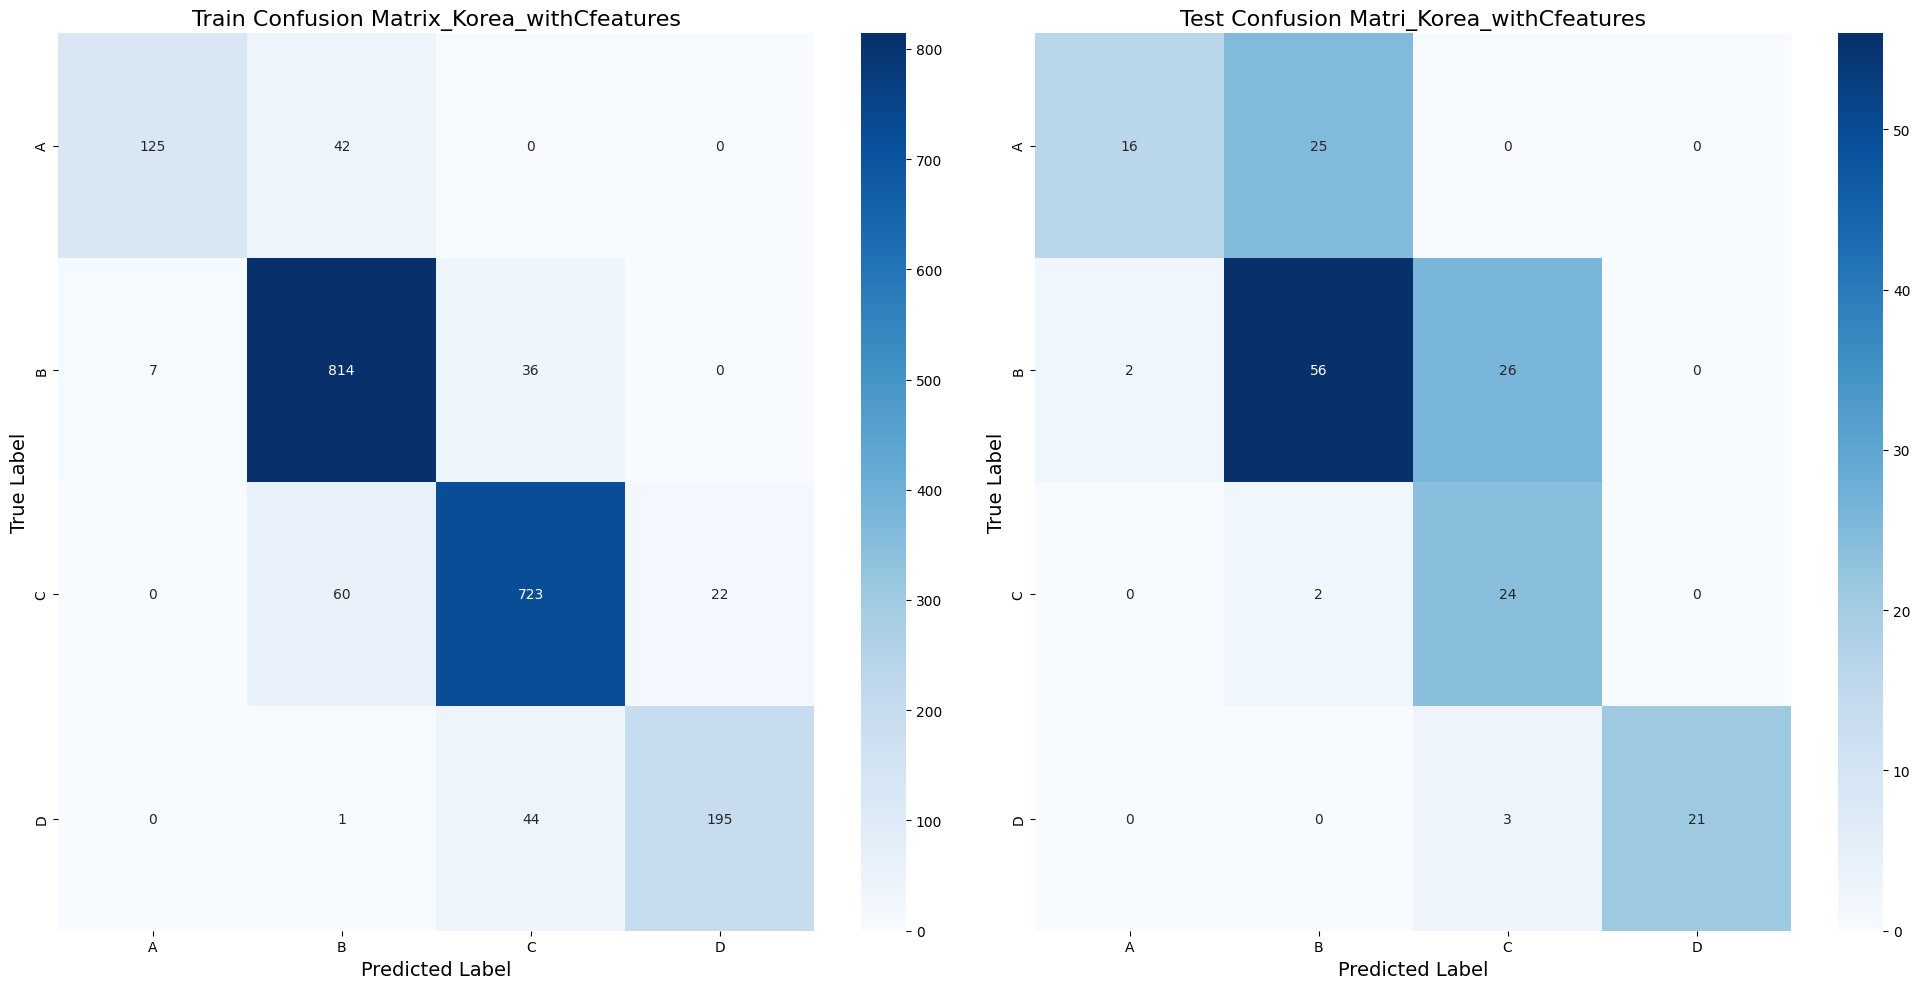

In [5]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Korea_withCfeatures', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Korea_withCfeatures', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (2069, 92, 4)


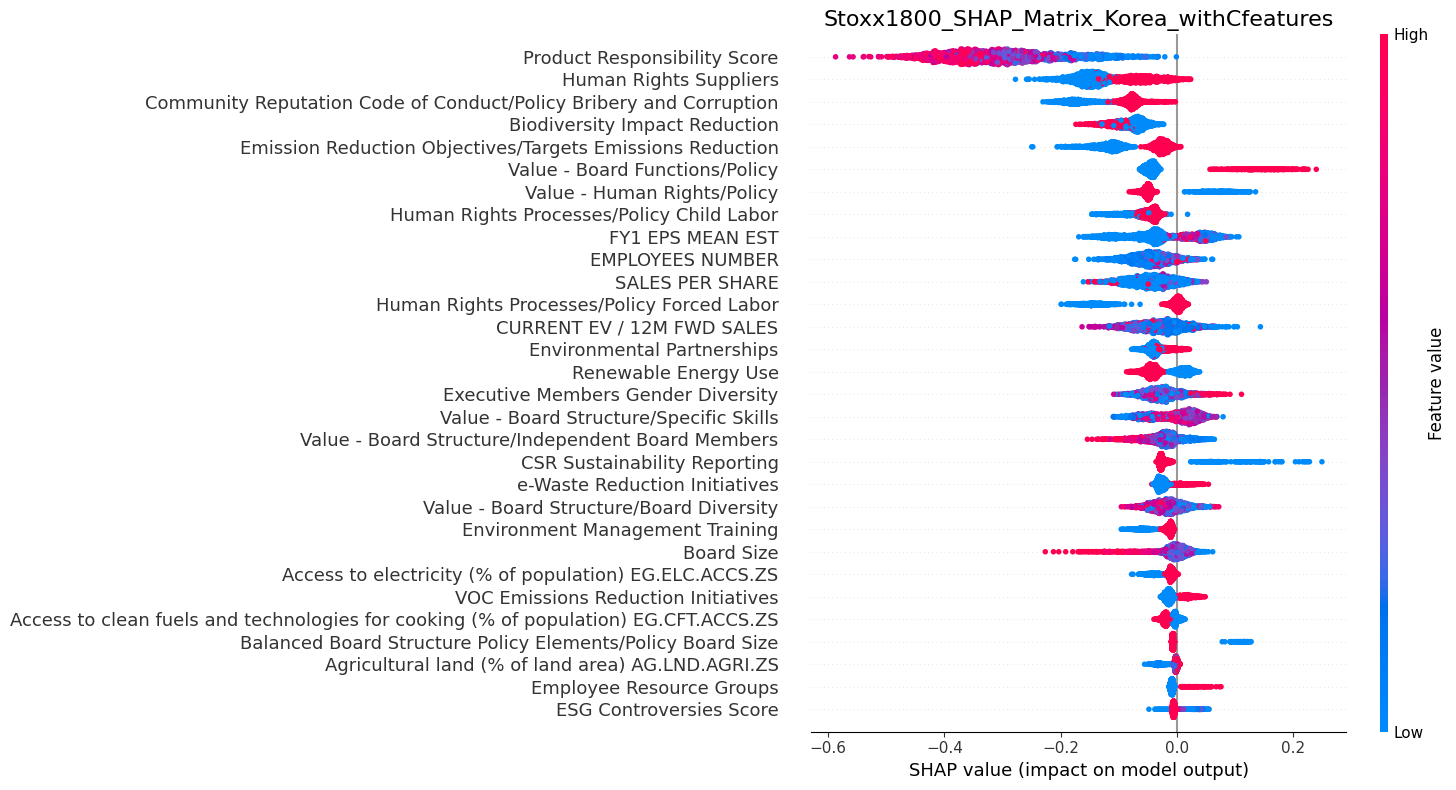

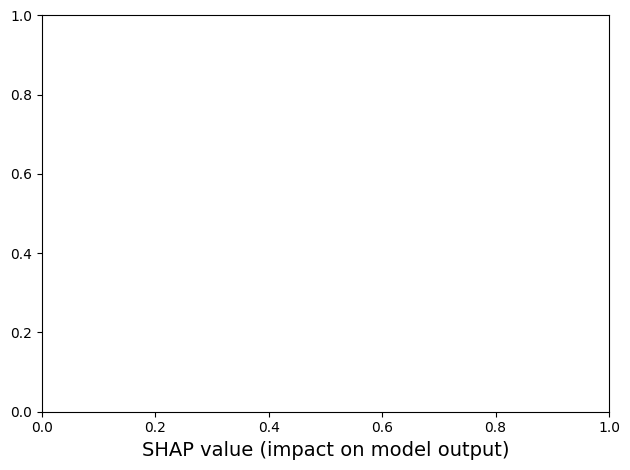

In [6]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Matrix_Korea_withCfeatures", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [123]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.1, 'lambda': 3, 'alpha': 2}

Train Results: Accuracy: 0.7709038182696955 F1 Score: 0.7660229523537213 AUC: 0.9370188314439105 prAUC: 0.8132040003787425
Test Results: Accuracy: 0.6228571428571429 F1 Score: 0.6216419428091223 AUC: 0.8593964272736772 prAUC: 0.7011073300737447


In [124]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8503439662856945, 'gamma': 1, 'learning_rate': 0.2605199419576296, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 715, 'reg_alpha': 7, 'reg_lambda': 2, 'subsample': 0.513255655270811}

Train Results: Accuracy: 0.7559207346544224 F1 Score: 0.7505284547792679 AUC: 0.9300118869154912 prAUC: 0.7945104681107967
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.5616880851633317 AUC: 0.8553950318483177 prAUC: 0.6969508955301742


#### (2) 亚洲数据

In [59]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong', 'Singapore','Thailand','Malaysia','Indonesia','India','Japan','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'Korea']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 India         713
 Japan         503
 Hong Kong     376
 Malaysia      361
 Thailand      191
 Taiwan        187
 Singapore      92
 Indonesia      88
 Vitnam         26
 Name: count, dtype: int64,
 Market
 Korea    175
 Name: count, dtype: int64)

In [60]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [61]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators = 300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.765819209039548 F1 Score: 0.7605016225844703 AUC: 0.9354022421266377 prAUC: 0.812198358135477
Test Results: Accuracy: 0.6514285714285715 F1 Score: 0.6417106918238993 AUC: 0.876484082423125 prAUC: 0.7208077106306541


In [62]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 3, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7516949152542373 F1 Score: 0.7447848628652909 AUC: 0.9249686408070226 prAUC: 0.7808705630384559
Test Results: Accuracy: 0.6457142857142857 F1 Score: 0.6362069946928731 AUC: 0.8761846166763458 prAUC: 0.7250677168136275


In [63]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.05, 'lambda': 3, 'alpha': 3}

Train Results: Accuracy: 0.7516949152542373 F1 Score: 0.7447848628652909 AUC: 0.9249686408070226 prAUC: 0.7808705630384559
Test Results: Accuracy: 0.6457142857142857 F1 Score: 0.6362069946928731 AUC: 0.8761846166763458 prAUC: 0.7250677168136275


In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7083329005048297, 'gamma': 3, 'learning_rate': 0.3820213214995577, 'max_depth': 14, 'min_child_weight': 5, 'n_estimators': 673, 'reg_alpha': 5, 'reg_lambda': 7, 'subsample': 0.7141572374700539}

Train Results: Accuracy: 0.7231638418079096 F1 Score: 0.7132487941106239 AUC: 0.9064928742714966 prAUC: 0.7293759387609917
Test Results: Accuracy: 0.6457142857142857 F1 Score: 0.6359486256414942 AUC: 0.8684564280326612 prAUC: 0.708178446997505


In [69]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=20,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8200564971751413 F1 Score: 0.8167849560052086 AUC: 0.9606119597772999 prAUC: 0.8818639576240077
Test Results: Accuracy: 0.6342857142857142 F1 Score: 0.6403140307796792 AUC: 0.8741135762642314 prAUC: 0.717027843247122


### 1.1.4 预测香港

In [130]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Japan','Korea','Taiwan'])]
test_data = data[data['Market'] == 'Hong Kong']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China     1003
 Japan      503
 Taiwan     187
 Korea      175
 Name: count, dtype: int64,
 Market
 Hong Kong    376
 Name: count, dtype: int64)

In [131]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [132]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7826552462526767 F1 Score: 0.7783402269296188 AUC: 0.9465676882489623 prAUC: 0.8503838983092451
Test Results: Accuracy: 0.6356382978723404 F1 Score: 0.6323065391163045 AUC: 0.8402840886389904 prAUC: 0.57430040631691


In [142]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=20,                # 降低树的深度
    n_estimators=2000,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.800321199143469 F1 Score: 0.7969719532545158 AUC: 0.9545777399138327 prAUC: 0.8716411590240702
Test Results: Accuracy: 0.6436170212765957 F1 Score: 0.6420347668053353 AUC: 0.840859947390731 prAUC: 0.5726331383858343


In [134]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7933618843683083 F1 Score: 0.7899079996841611 AUC: 0.9519803328688097 prAUC: 0.8652168984098578
Test Results: Accuracy: 0.6382978723404256 F1 Score: 0.6356245093953834 AUC: 0.8392963443399921 prAUC: 0.5669556800744553


In [135]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'lambda': 1, 'alpha': 1}

Train Results: Accuracy: 0.8024625267665952 F1 Score: 0.799144710875986 AUC: 0.9552201998384865 prAUC: 0.8736925510047102
Test Results: Accuracy: 0.6356382978723404 F1 Score: 0.6329688655862094 AUC: 0.8433946519100454 prAUC: 0.5799816928377703


In [136]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=8
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8769744131561081, 'gamma': 1, 'learning_rate': 0.178807585701814, 'max_depth': 15, 'min_child_weight': 6, 'n_estimators': 671, 'reg_alpha': 1, 'reg_lambda': 4, 'subsample': 0.681814801189647}

Train Results: Accuracy: 0.8795503211991434 F1 Score: 0.8784187596091566 AUC: 0.9832312782662259 prAUC: 0.9493940709745045
Test Results: Accuracy: 0.6196808510638298 F1 Score: 0.620490502405396 AUC: 0.8380635592921732 prAUC: 0.5619562673810898


#### （1）亚洲数据

In [ ]:
data = pd.read_csv('data_to_fit_suppliment_v3.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China','Korea' 'Singapore','Thailand','Malaysia','Indonesia','India','Japan','Taiwan','Vitnam'])]
test_data = data[data['Market'] == 'Hong Kong']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

### 1.1.5 预测台湾

In [143]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['China', 'Hong Kong','Japan','Korea'])]
test_data = data[data['Market'] == 'Taiwan']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 China        1003
 Japan         503
 Hong Kong     376
 Korea         175
 Name: count, dtype: int64,
 Market
 Taiwan    187
 Name: count, dtype: int64)

In [144]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [145]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7846378220709771 F1 Score: 0.7816941992527111 AUC: 0.9428150374191212 prAUC: 0.8378506154624057
Test Results: Accuracy: 0.6631016042780749 F1 Score: 0.6196554335273696 AUC: 0.8186421709206558 prAUC: 0.6851601142448203


In [153]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8254739912493924 F1 Score: 0.8223405254368267 AUC: 0.9618317522584312 prAUC: 0.887217111912577
Test Results: Accuracy: 0.6684491978609626 F1 Score: 0.639374553396249 AUC: 0.8077094032057267 prAUC: 0.6744595719730424


In [147]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1200}

Train Results: Accuracy: 0.7924161400097229 F1 Score: 0.7890006085801382 AUC: 0.9474365511261611 prAUC: 0.8476814700281157
Test Results: Accuracy: 0.6470588235294118 F1 Score: 0.6021537417236539 AUC: 0.8205214765644819 prAUC: 0.6842057057373975


In [148]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.1, 'lambda': 2, 'alpha': 3}

Train Results: Accuracy: 0.7637335926105979 F1 Score: 0.7586330904546166 AUC: 0.9320834928493573 prAUC: 0.8047426271706491
Test Results: Accuracy: 0.6363636363636364 F1 Score: 0.5925452949157954 AUC: 0.8070607736558676 prAUC: 0.6679575127731475


In [149]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8769744131561081, 'gamma': 1, 'learning_rate': 0.178807585701814, 'max_depth': 15, 'min_child_weight': 6, 'n_estimators': 671, 'reg_alpha': 1, 'reg_lambda': 4, 'subsample': 0.681814801189647}

Train Results: Accuracy: 0.8784637822070978 F1 Score: 0.8774438444714848 AUC: 0.981442556512247 prAUC: 0.9417208493539881
Test Results: Accuracy: 0.6470588235294118 F1 Score: 0.6118973212915266 AUC: 0.7991595167478756 prAUC: 0.659364348763441


## 1.2 东南亚

### 1.2.1 预测印尼

In [154]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

train_data = data[data['Market'].isin(['India','Vitnam','Singapore','Thailand','Malaysia'])]
test_data = data[data['Market'] == 'Indonesia']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Thailand     191
 Singapore     92
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Indonesia    88
 Name: count, dtype: int64)

In [155]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [156]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7982646420824295 F1 Score: 0.7913118226901861 AUC: 0.9445594865566861 prAUC: 0.8384903805515662
Test Results: Accuracy: 0.5681818181818182 F1 Score: 0.5289017017465294 AUC: 0.8462522722234866 prAUC: 0.655493612274573


In [161]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=13,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.89587852494577 F1 Score: 0.8939205321494335 AUC: 0.9848544017661331 prAUC: 0.9512304427483833
Test Results: Accuracy: 0.5795454545454546 F1 Score: 0.5401561057677992 AUC: 0.8177984740022665 prAUC: 0.6386823734385638


In [158]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8054953000723066 F1 Score: 0.7989466807637678 AUC: 0.9505637652603385 prAUC: 0.8533657794304719
Test Results: Accuracy: 0.5909090909090909 F1 Score: 0.5497406329302881 AUC: 0.8270626290211022 prAUC: 0.6366470116938453


In [159]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9052783803326103 F1 Score: 0.9035191903638693 AUC: 0.9867900483818428 prAUC: 0.9558602206521418
Test Results: Accuracy: 0.5568181818181818 F1 Score: 0.5202020202020202 AUC: 0.8263676449822313 prAUC: 0.6347644400988992


In [160]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.8756326825741142 F1 Score: 0.8720437611532962 AUC: 0.9776352051358218 prAUC: 0.9238149896558058
Test Results: Accuracy: 0.625 F1 Score: 0.5954713390058216 AUC: 0.8253338555298526 prAUC: 0.6259616312037459


In [175]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=13,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.07,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.9,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsample_bylevel=0.815,
    min_child_weight=7
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8749096167751266 F1 Score: 0.8711901276762354 AUC: 0.9758268549982234 prAUC: 0.9185542767494718
Test Results: Accuracy: 0.625 F1 Score: 0.5935880736359916 AUC: 0.8344410376526767 prAUC: 0.6471623902709103


### 1.2.2 预测印度

In [176]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

train_data = data[data['Market'].isin(['Indonesia','Vitnam','Singapore','Thailand','Malaysia'])]
test_data = data[data['Market'] == 'India']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Malaysia     361
 Thailand     191
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 India    713
 Name: count, dtype: int64)

In [177]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)
# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [178]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7889182058047494 F1 Score: 0.781488398085611 AUC: 0.9454160743015928 prAUC: 0.8431410493742086
Test Results: Accuracy: 0.6746143057503506 F1 Score: 0.6646461746333117 AUC: 0.8487551087223516 prAUC: 0.6224066707999891


In [194]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.02,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8825857519788918 F1 Score: 0.8803964867859775 AUC: 0.9843002327576578 prAUC: 0.9532600182546518
Test Results: Accuracy: 0.6914446002805049 F1 Score: 0.6805825598196111 AUC: 0.8504181416025157 prAUC: 0.6336704933464723


In [180]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.787598944591029 F1 Score: 0.7795994062996751 AUC: 0.9456364900344105 prAUC: 0.8461237586494541
Test Results: Accuracy: 0.6802244039270687 F1 Score: 0.6716981309295494 AUC: 0.8488447297347252 prAUC: 0.6196503292199773


In [181]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8575197889182058 F1 Score: 0.853313108039756 AUC: 0.9778983607749955 prAUC: 0.9343026027057209
Test Results: Accuracy: 0.6690042075736325 F1 Score: 0.6626442826713168 AUC: 0.8452020855578708 prAUC: 0.6210421132627509


In [182]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8034282764658811, 'gamma': 4, 'learning_rate': 0.13464611457443748, 'max_depth': 15, 'min_child_weight': 4, 'n_estimators': 724, 'reg_alpha': 7, 'reg_lambda': 3, 'subsample': 0.5806106436270022}

Train Results: Accuracy: 0.679419525065963 F1 Score: 0.6416681990680273 AUC: 0.8678163219596533 prAUC: 0.6264294102830703
Test Results: Accuracy: 0.6690042075736325 F1 Score: 0.6373979438487418 AUC: 0.8166837086074801 prAUC: 0.5412169019395159


### 1.2.3 预测新加坡

In [195]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

train_data = data[data['Market'].isin(['India','Vitnam','Thailand','Malaysia','Indonesia'])]
test_data = data[data['Market'] == 'Singapore']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Thailand     191
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Singapore    92
 Name: count, dtype: int64)

In [196]:

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [197]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7846265409717187 F1 Score: 0.7776130391031895 AUC: 0.9425633619895555 prAUC: 0.83633532261334
Test Results: Accuracy: 0.6630434782608695 F1 Score: 0.6421154194054152 AUC: 0.8655521418976112 prAUC: 0.5311335213248107


In [198]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9035532994923858 F1 Score: 0.9017237797684508 AUC: 0.9861045517480347 prAUC: 0.9568709793601922
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6546583850931676 AUC: 0.878703157575506 prAUC: 0.5757680231680938


In [199]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8107324147933285 F1 Score: 0.8046121933394147 AUC: 0.9553535600855259 prAUC: 0.873646915694295
Test Results: Accuracy: 0.6739130434782609 F1 Score: 0.6589109163617799 AUC: 0.8718140098122421 prAUC: 0.5647950624616621


In [200]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 25, 'learning_rate': 0.05, 'lambda': 2, 'gamma': 2, 'alpha': 1}

Train Results: Accuracy: 0.7868020304568528 F1 Score: 0.7794060295841774 AUC: 0.9426531807033252 prAUC: 0.8352678704814357
Test Results: Accuracy: 0.6739130434782609 F1 Score: 0.6447204968944099 AUC: 0.8508650037312014 prAUC: 0.5138563565817855


In [201]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9386644568953224, 'gamma': 3, 'learning_rate': 0.45354321213255866, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 786, 'reg_alpha': 1, 'reg_lambda': 8, 'subsample': 0.8926703255569718}

Train Results: Accuracy: 0.7657722987672226 F1 Score: 0.755941764678552 AUC: 0.9240810515535379 prAUC: 0.7886894701094599
Test Results: Accuracy: 0.6956521739130435 F1 Score: 0.6766167336499816 AUC: 0.8256896205789561 prAUC: 0.4796800420792088


In [217]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=8,              # L2 正则化
    gamma =3,                   # 添加 gamma 限制分裂
    max_depth=12,                # 降低树的深度
    n_estimators=800,          # 树的数量
    learning_rate=0.45,        # 降低学习率
    subsample=0.9,             # 样本采样率
    colsample_bytree=0.93,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsample_bylevel=0.89,
    min_child_weight=1
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7556200145032632 F1 Score: 0.7450075506166132 AUC: 0.9230386841186163 prAUC: 0.7803351180084571
Test Results: Accuracy: 0.6847826086956522 F1 Score: 0.6531416326812746 AUC: 0.8337773578341672 prAUC: 0.4681723709362884


### 1.2.4 预测马来西亚

In [218]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

train_data = data[data['Market'].isin(['Indonesia','Vitnam','Singapore','Thailand','India'])]
test_data = data[data['Market'] == 'Malaysia']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Thailand     191
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Malaysia    361
 Name: count, dtype: int64)

In [219]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [220]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7981981981981981 F1 Score: 0.791930343271582 AUC: 0.9455987125065985 prAUC: 0.8441592248317172
Test Results: Accuracy: 0.6925207756232687 F1 Score: 0.6604297627588921 AUC: 0.861073030198289 prAUC: 0.6251576194389107


In [221]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=25,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.8,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8972972972972973 F1 Score: 0.8955295220744086 AUC: 0.9864842789525174 prAUC: 0.9616552935310738
Test Results: Accuracy: 0.6842105263157895 F1 Score: 0.6451559059592301 AUC: 0.8542923452819758 prAUC: 0.6443752170800143


In [222]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 2, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7837837837837838 F1 Score: 0.7749263003880656 AUC: 0.9378183311883878 prAUC: 0.826527299233824
Test Results: Accuracy: 0.7202216066481995 F1 Score: 0.6878799197073061 AUC: 0.8596032693893796 prAUC: 0.6134208811135198


In [223]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8693693693693694 F1 Score: 0.8657677518136682 AUC: 0.9792532727399362 prAUC: 0.937916329694248
Test Results: Accuracy: 0.6980609418282548 F1 Score: 0.6639987856451076 AUC: 0.8545207471929156 prAUC: 0.6330640775816034


In [224]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7174367377057973, 'gamma': 1, 'learning_rate': 0.4150566973395904, 'max_depth': 13, 'min_child_weight': 8, 'n_estimators': 724, 'reg_alpha': 4, 'reg_lambda': 7, 'subsample': 0.7507581473435998}

Train Results: Accuracy: 0.7972972972972973 F1 Score: 0.7882688046577535 AUC: 0.9398608037981309 prAUC: 0.8198078896582626
Test Results: Accuracy: 0.7008310249307479 F1 Score: 0.6636069921801859 AUC: 0.8524276969579798 prAUC: 0.6100780813696098


In [225]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=5,              # L2 正则化
    gamma=3,                   # 添加 gamma 限制分裂
    max_depth=11,               # 降低树的深度
    n_estimators=586,          # 树的数量
    learning_rate=0.13,        # 降低学习率
    subsample=0.642,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsample_bylevel=0.98,
    min_child_weight=2,
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7639639639639639 F1 Score: 0.7544677034106312 AUC: 0.9234509460713114 prAUC: 0.7896754159414406
Test Results: Accuracy: 0.703601108033241 F1 Score: 0.6706206264237382 AUC: 0.8608433112182268 prAUC: 0.612903336050379


### 1.2.5 预测泰国

In [226]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

train_data = data[data['Market'].isin(['India','Vitnam','Indonesia','Singapore','Malaysia'])]
test_data = data[data['Market'] == 'Thailand']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Singapore     92
 Indonesia     88
 Vitnam        26
 Name: count, dtype: int64,
 Market
 Thailand    191
 Name: count, dtype: int64)

In [229]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [230]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.79296875 F1 Score: 0.7855260148165508 AUC: 0.9435597646308708 prAUC: 0.8382797953172605
Test Results: Accuracy: 0.7172774869109948 F1 Score: 0.7063486552564002 AUC: 0.8767496147650368 prAUC: 0.7103248849009088


In [245]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7953125 F1 Score: 0.7871422149530792 AUC: 0.9418383706498821 prAUC: 0.8365179046613589
Test Results: Accuracy: 0.7382198952879581 F1 Score: 0.7244676753676974 AUC: 0.8724781231845785 prAUC: 0.6991030720987068


In [232]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7953125 F1 Score: 0.7871422149530792 AUC: 0.9418383706498821 prAUC: 0.8365179046613589
Test Results: Accuracy: 0.7382198952879581 F1 Score: 0.7244676753676974 AUC: 0.8724781231845785 prAUC: 0.6991030720987068


In [233]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 2, 'alpha': 2}

Train Results: Accuracy: 0.7828125 F1 Score: 0.7744013051438927 AUC: 0.9348206177581051 prAUC: 0.8118615818172031
Test Results: Accuracy: 0.7172774869109948 F1 Score: 0.7043861211905984 AUC: 0.8699331866215954 prAUC: 0.7041229787358021


In [234]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8447411578889518, 'gamma': 1, 'learning_rate': 0.033332831606807715, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 443, 'reg_alpha': 1, 'reg_lambda': 3, 'subsample': 0.9299702033681603}

Train Results: Accuracy: 0.8515625 F1 Score: 0.8451548230412405 AUC: 0.9703496182411048 prAUC: 0.9088817486106587
Test Results: Accuracy: 0.7172774869109948 F1 Score: 0.7078176701136458 AUC: 0.8682686345308475 prAUC: 0.6590364716888778


### 1.2.6 预测越南

In [3]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')

train_data = data[data['Market'].isin(['India','Indonesia','Singapore','Malaysia','Thailand'])]
test_data = data[data['Market'] == 'Vitnam']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 India        713
 Malaysia     361
 Thailand     191
 Singapore     92
 Indonesia     88
 Name: count, dtype: int64,
 Market
 Vitnam    26
 Name: count, dtype: int64)

In [4]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [7]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7896193771626298 F1 Score: 0.7815694052813389
Test Results: Accuracy: 0.8076923076923077 F1 Score: 0.8084249084249084


In [8]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8186851211072664 F1 Score: 0.8132246135498171
Test Results: Accuracy: 0.8076923076923077 F1 Score: 0.8084249084249084


In [9]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7868512110726643 F1 Score: 0.777023347967483
Test Results: Accuracy: 0.7692307692307693 F1 Score: 0.7720279720279721


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.871280276816609 F1 Score: 0.8672952817439029
Test Results: Accuracy: 0.8076923076923077 F1 Score: 0.8084249084249084
